# Closest School Via Street Network

### Objetive: Clusterize a set of equipaments, given the street network distance between then

In [1]:
# list of imports
import osmnx as ox
import geopandas as gpd
import networkx as nx
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from multiprocessing import Pool
from functools import partial
import numpy as np
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
from shapely import wkt

ModuleNotFoundError: No module named 'osmnx'

In [126]:
# Load Data
polygons = gpd.read_file('./data/BGRI_2011/CONTINENTE/BGRI11_CONT.shp', dtype={'BGRI11': str})
# Schools for entire Country. It is less Accurate.
# sig = gpd.read_file('./data/escolas_portugal_corrigido/gdf_escolas_publicas_1CEB.shp', dtype={'CODCONCELH': int})
sig = gpd.read_file('./data/escolas_ourem/gdf_escolas_Ourem2019_capacidades.shp')



# Códido maluco do Jan

# Load Data
gdf_freguesias_CAOP2018 = gpd.read_file('./data/ourem_map_data/gdf_Freguesias_CAOP2018_Ourem.shp')
gdf_freguesias_CAOP2018 = gdf_freguesias_CAOP2018[gdf_freguesias_CAOP2018['code_mun']=='1421']
gpd_COS_municipio = gpd.read_file('./data/ourem_map_data/gpd_COS_Ourem.shp')
gdf_open_street2019_municipio = gpd.read_file('./data/ourem_map_data/gdf_open_street2019_Ourem.shp')


In [127]:
# Load Demand per BGRI Data
demand = pd.read_csv('./data/escolas_ourem/df_alunos_subseccao.csv', dtype={'Unnamed: 0':str})
demand = demand.rename(columns={'Unnamed: 0':'BGRI'})
demand.index = demand['BGRI']
demand = demand.drop(columns=['BGRI'])

In [128]:
# Clean SIG Data - USED for SCHOOLS in THE COUNTRY only
# sig.at[2117,'CODCONCELH'] = '1212'
# sig['CODCONCELH'] = sig['CODCONCELH'].astype(int).astype(str)
# sig['CODCONCELH'] = sig['CODCONCELH'].apply(lambda x: str(x).zfill(4))

In [129]:
def get_required_bgri(column, value):
    return polygons[polygons[column]==value]
def get_schools_network(column, value):
    return sig[sig[column]==value]

In [130]:
polygon = get_required_bgri('DTMN11', '1421')

# Used for SCHOOLS IN THE COUNTRY only
# schools = get_schools_network('CODCONCELH', '1421')
schools = sig


In [131]:
# Load 2019 enrolled Students per school
schools_enrolled = gpd.read_file('./data/oures_escolas_c_alunos_capacidades/gdf_escolas_Ourem2019_capacidades_alunos.shp')
schools_enrolled = schools_enrolled[['FID_x','Alunos_EPE','Alunos_1CE','Alunos_2CE','Alunos_3CE','Alunos_Sec']]
schools_complete = pd.merge(schools, schools_enrolled, how='left', left_on=[schools.FID], right_on=[schools_enrolled.FID_x] )

In [132]:
polygon['geometry'] = polygon.centroid

/home/fillipe/anaconda3/envs/pandana/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [133]:
import geopandas as gpd
import numpy as np
import pandas as pd

from scipy.spatial import cKDTree
from shapely.geometry import Point

gpd1 = gpd.GeoDataFrame([['John', 1, Point(1, 1)], ['Smith', 1, Point(2, 2)],
                         ['Soap', 1, Point(0, 2)]],
                        columns=['Name', 'ID', 'geometry'])
gpd2 = gpd.GeoDataFrame([['Work', Point(0, 1.1)], ['Shops', Point(2.5, 2)],
                         ['Home', Point(1, 1.1)]],
                        columns=['Place', 'geometry'])

def ckdnearest(gdA, gdB):
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA, gdB.loc[idx, gdB.columns != 'geometry'].reset_index(),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

In [134]:
# schools = schools.reset_index()
schools['point'] = schools.geometry

#### Rotina para o Cálculo começa aqui

In [135]:
schools_preEscolar = schools[schools['Capacidade']!=0].reset_index()

In [136]:

nA = np.array(list(zip(polygon.geometry.x, polygon.geometry.y)) )
nB = np.array(list(zip(schools_preEscolar.geometry.x, schools_preEscolar.geometry.y)) )
btree = cKDTree(nB)
dist, idx = btree.query(nA, k=1)
polygon['place'] = idx
polygon['dist'] = dist


/home/fillipe/anaconda3/envs/pandana/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/fillipe/anaconda3/envs/pandana/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [137]:
# Correlate the DEMAND BGRI with the School associated
polygon = pd.merge(polygon, schools_preEscolar[['Nome_Escol', 'point']], left_on=[polygon.place], how='left', right_on=[schools_preEscolar.index] )
polygon = polygon.drop(columns='key_0')

In [138]:
listOfLines = []
for e in polygon.iterrows():
    line = LineString([[e[1].geometry.x, e[1].geometry.y], [e[1].point.x, e[1].point.y]])
    listOfLines.append(line)
polygon['line'] = listOfLines

In [139]:
linesGPD = gpd.GeoDataFrame(polygon[['BGRI11', 'dist','place', 'Nome_Escol']], geometry=polygon.line)

In [140]:
polygon_1421 = get_required_bgri('DTMN11', '1421')

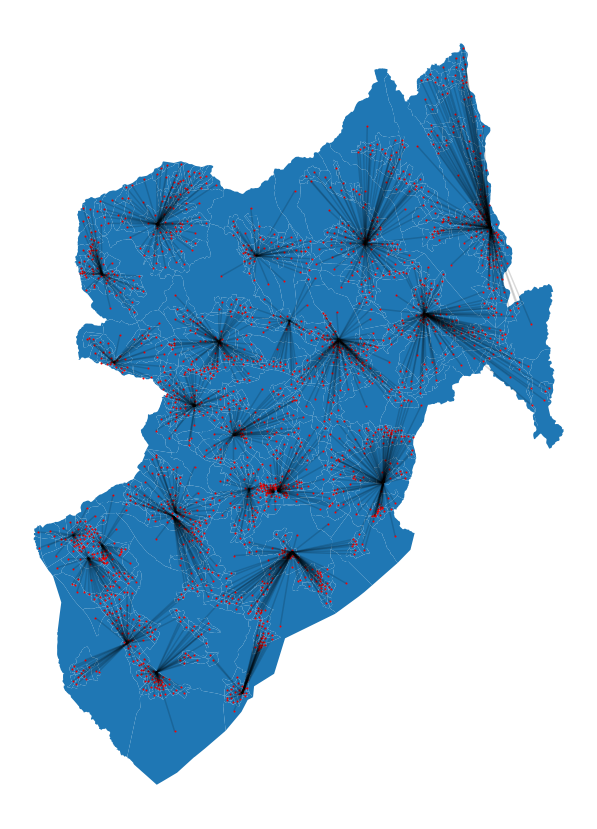

In [141]:
fig, ax = plt.subplots(figsize=(15,15))
linesGPD.plot(ax=ax, alpha=0.15, color='black')

polygon_1421.plot(ax=ax)
ax.set_axis_off()

polygon.plot(ax=ax, markersize=1, color='red', marker='o', label='centroid')

In [142]:
# Get Demand Data for each BGRI
polygon = pd.merge(polygon, demand[['Pre_escolar_Proj_2040', '1_CEB_Proj_2040', '2_CEB_Proj_2040', '3_CEB_Proj_2040']], how='left', left_on=[polygon.BGRI11], right_on=[demand.index])
# Clear Polygon Data
polygon = polygon.rename(columns={'key_0':'BGRI'})
polygon.index = polygon.BGRI
polygon = polygon.drop(columns={'BGRI'})
polygon['sum_ceb2_ceb3'] = polygon['2_CEB_Proj_2040']+polygon['3_CEB_Proj_2040']

# Get the Demand for the schools
sumOfDemand = polygon[['Pre_escolar_Proj_2040', '1_CEB_Proj_2040','sum_ceb2_ceb3', 'place']].groupby('place').sum()
schools_preEscolar = pd.merge(schools_preEscolar, sumOfDemand, how='left', left_on=[schools_preEscolar.index], right_on=[sumOfDemand.index])
schools_preEscolar = schools_preEscolar.drop(columns='key_0')

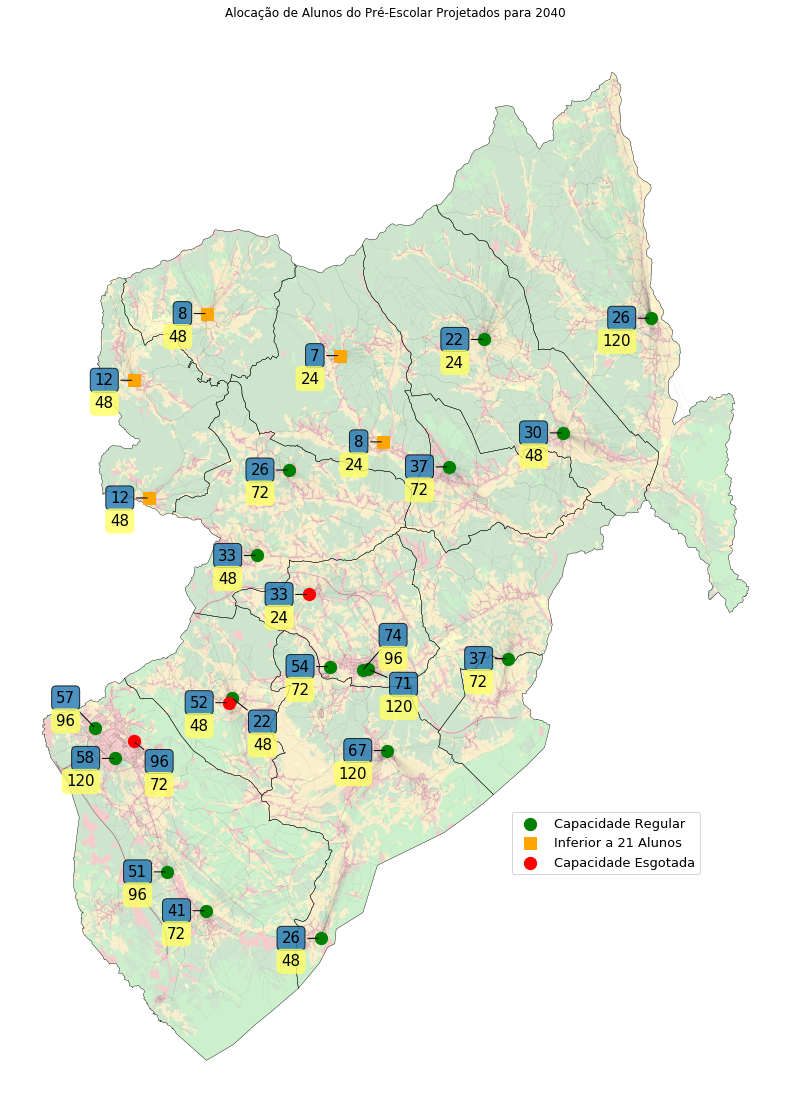

In [143]:
# # Códido maluco do Jan

# # Load Data
# gdf_freguesias_CAOP2018 = gpd.read_file('./data/ourem_map_data/gdf_Freguesias_CAOP2018_Ourem.shp')
# gdf_freguesias_CAOP2018 = gdf_Freguesias_CAOP2018[gdf_Freguesias_CAOP2018['code_mun']=='1421']
# gpd_COS_municipio = gpd.read_file('./data/ourem_map_data/gpd_COS_Ourem.shp')
# gdf_open_street2019_municipio = gpd.read_file('./data/ourem_map_data/gdf_open_street2019_Ourem.shp')

# _-------------_ Uso do Solo: Categorias _-----------_


#recebe RGB em dicionários de float e devolve o hexadecimal correspondente
def rgb_to_hex (diccionario_cores): 
    dict_novo = {}
    for nome in diccionario_cores:
        dict_novo [nome] = '#%02x%02x%02x'%tuple(int(i * 255) for i in diccionario_cores[nome])
    return(dict_novo)
#define RGB para cada tipo de ocupação de solo 
colors_cos = {'Territórios artificializados': (0.8, 0, 0),
              'Agricultura': (0.9, 0.7, 0.03), 
              'Pastagens': (0.96, 0.93, 0.03),
              'Sistemas agro-florestais': (0.85, 0.6, 0),
              'Florestas': (0, 0.5, 0), 
              'Matos': (0, 0.7, 0),
              'Espaços descobertos ou com vegetação esparsa': (0.9, 0.9, 0.5),
              'Zonas húmidas': (0.9, 0.9, 0.5), 
              'Corpos de água': (0.3, 0.6, 1)}
colors_cos_hexa = rgb_to_hex(colors_cos)


# _-------------_ Estradas: Categorias _-----------_

motorway = ['motorway', 'motorway_link']
primary = ['primary', 'trunk', 'secondary']
n_mapear = ['cycleway', 'steps', 'track','track_grade1','track_grade2',
            'track_grade3','track_grade4','track_grade5','pedestrian',
            'footway', 'unclassified','path']

dict_temp = {}
for nome in gdf_open_street2019_municipio.fclass.unique(): 
    if nome in motorway:
        dict_temp [nome] = list((0.4,6))
    elif nome in primary: 
        dict_temp [nome] = list((0.3,4))
    elif nome in n_mapear:
        dict_temp [nome] = list((0.2,1))
    else: 
        dict_temp [nome] = list((0.3,2))



# _-------------_ Criação do Gráfico _-----------_





fig, ax = plt.subplots(figsize=(20, 20))

#Plota os limites das freguesias 
gdf_freguesias_CAOP2018.plot(ax=ax,
                        facecolor='None', edgecolor='black', linewidth=0.4, zorder=20)

#Plota ocupação e uso de solo por categoria, em função do esquema de cores definido em colors_cos_hexa
for categoria, data in gpd_COS_municipio.groupby('Megaclasse'):
    # Define the color for each group using the dictionary
    color = colors_cos_hexa[categoria]
    # Plot each group using the color defined above
    data.plot(color=color, ax=ax, alpha=0.2, zorder=10)

#Plota a rede de estradas, em função da linewidths e alphas definido em dict_temp 
for ctype, data in gdf_open_street2019_municipio.groupby('fclass'):
    alpha = dict_temp[ctype][0]
    linewidth = dict_temp[ctype][0]
    data.plot(color = 'black', ax=ax, alpha=alpha, 
              linewidth=linewidth, zorder=15)


linesGPD.plot(ax=ax, alpha=0.02, color='black', zorder=40)
markersize = 150
# If the School has critic mass
schools_preEscolar[(schools_preEscolar['Capacidade']>schools_preEscolar['Pre_escolar_Proj_2040']) & (schools_preEscolar['Capacidade']>0)].plot(ax=ax, markersize=markersize, color='green', marker='o', label='Capacidade Regular', zorder=50)
# IF the school is a closing Candidate
schools_preEscolar[(schools_preEscolar['Capacidade']>0) & (schools_preEscolar['Pre_escolar_Proj_2040']<=22)].plot(ax=ax, markersize=markersize, color='#FFA500', marker='s', label='Inferior a 21 Alunos ', zorder=60)
# If the school is Full
schools_preEscolar[(schools_preEscolar['Capacidade']<schools_preEscolar['Pre_escolar_Proj_2040']) & (schools_preEscolar['Capacidade']>0)].plot(ax=ax, markersize=markersize, color='red', marker='o', label='Capacidade Esgotada', zorder=70)
plt.legend(prop={'size':13}, bbox_to_anchor = (0.9,0.28))
# Offset for different cases and generalization

for idx, row in schools_preEscolar.iterrows():
    offset = {'x':-20, 'y':0}
    
    # Change the bbox Offset for the cases where colision happens
    offset = {'x':-20, 'y':30 } if idx==0 else offset
    offset = {'x':40, 'y':35 } if idx==24 else offset
    offset = {'x':45, 'y':-15 } if idx==10 else offset
    offset = {'x':40, 'y':-24 } if idx==22 else offset
    offset = {'x':35, 'y':-20 } if idx==17 else offset
    ax.annotate(int(row['Pre_escolar_Proj_2040']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8),
             arrowprops=dict(arrowstyle="-", alpha=1));
    ax.annotate(int(row['Capacidade']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']-23), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8, color='#FFFF66')
             );
    
    
    
ax.set_axis_off()

plt.title('Alocação de Alunos do Pré-Escolar Projetados para 2040') 

plt.show()

In [144]:
schools_preEscolar =  pd.merge(schools_preEscolar, schools_enrolled, how='left', left_on=[schools_preEscolar.FID], right_on=[schools_enrolled.FID_x])

No handles with labels found to put in legend.


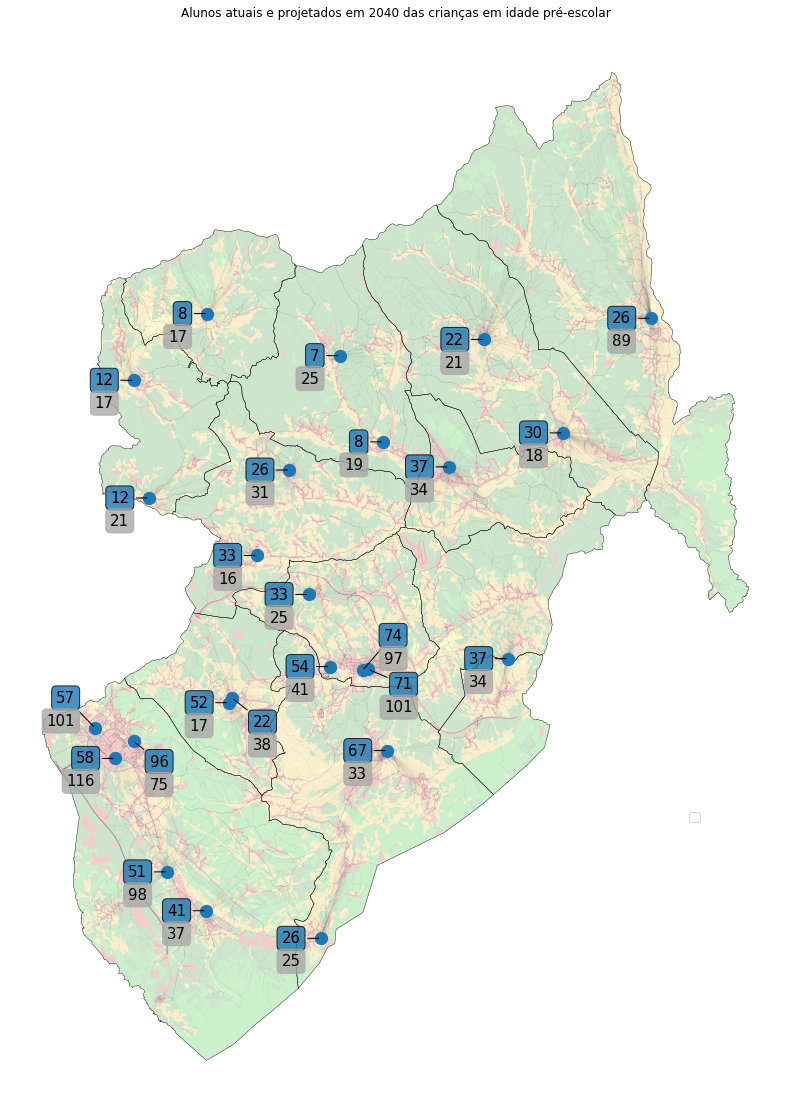

In [145]:
# ENROLLED PLOT

fig, ax = plt.subplots(figsize=(20, 20))

#Plota os limites das freguesias 
gdf_freguesias_CAOP2018.plot(ax=ax,
                        facecolor='None', edgecolor='black', linewidth=0.4, zorder=20)

#Plota ocupação e uso de solo por categoria, em função do esquema de cores definido em colors_cos_hexa
for categoria, data in gpd_COS_municipio.groupby('Megaclasse'):
    # Define the color for each group using the dictionary
    color = colors_cos_hexa[categoria]
    # Plot each group using the color defined above
    data.plot(color=color, ax=ax, alpha=0.2, zorder=10)

#Plota a rede de estradas, em função da linewidths e alphas definido em dict_temp 
for ctype, data in gdf_open_street2019_municipio.groupby('fclass'):
    alpha = dict_temp[ctype][0]
    linewidth = dict_temp[ctype][0]
    data.plot(color = 'black', ax=ax, alpha=alpha, 
              linewidth=linewidth, zorder=15)


linesGPD.plot(ax=ax, alpha=0.02, color='black', zorder=40)
markersize = 150

schools_preEscolar.plot(ax=ax, zorder=60, markersize=markersize)
plt.legend(prop={'size':13}, bbox_to_anchor = (0.9,0.28))
# Offset for different cases and generalization

for idx, row in schools_preEscolar.iterrows():
    offset = {'x':-20, 'y':0}   
    
    # Change the bbox Offset for the cases where colision happens
    offset = {'x':-20, 'y':30 } if idx==0 else offset
    offset = {'x':40, 'y':35 } if idx==24 else offset
    offset = {'x':45, 'y':-15 } if idx==10 else offset
    offset = {'x':40, 'y':-24 } if idx==22 else offset
    offset = {'x':35, 'y':-20 } if idx==17 else offset
    ax.annotate(int(row['Pre_escolar_Proj_2040']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8),
             arrowprops=dict(arrowstyle="-", alpha=1));
    ax.annotate(int(row['Alunos_EPE']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']-23), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8, color='#A9A9A9')
             );
    
    
    
ax.set_axis_off()

plt.title('Alunos atuais e projetados em 2040 das crianças em idade pré-escolar') 

plt.show()

In [146]:
# # Plot 'Pre-Escolar'


# fig, ax = plt.subplots(figsize=(15,15))

    
  
# #     bbox_props = dict(boxstyle="square")
# #     t = ax.text(row['geometry'].x,row['geometry'].y,int(row['Pre_escolar_Proj_2040']), ha="center", va="center",
# #             size=15,
# #             bbox=bbox_props)
    
# ax.set_axis_off()

# plt.title('Alocação de Alunos do Pré-Escolar Projetados para 2040') 

# plt.show()

#### PRIMÁRIO

In [147]:
schools_1 = schools[schools['Capacida_1']!=0].reset_index()
polygon_1 = polygon_1421
polygon_1.geometry = polygon_1421.centroid

/home/fillipe/anaconda3/envs/pandana/lib/python3.6/site-packages/geopandas/geodataframe.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[geo_column_name] = level


In [148]:
nA = np.array(list(zip(polygon.geometry.x, polygon.geometry.y)) )
nB = np.array(list(zip(schools_1.geometry.x, schools_1.geometry.y)) )
btree = cKDTree(nB)
dist, idx = btree.query(nA, k=1)
polygon_1['place'] = idx
polygon_1['dist'] = dist

/home/fillipe/anaconda3/envs/pandana/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/fillipe/anaconda3/envs/pandana/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [149]:
# Correlate the DEMAND BGRI with the School associated
polygon_1 = pd.merge(polygon_1, schools_1[['Nome_Escol', 'point']], left_on=[polygon_1.place], how='left', right_on=[schools_1.index] )
polygon_1 = polygon_1.drop(columns='key_0')

In [150]:
listOfLines = []
for e in polygon_1.iterrows():
    line = LineString([[e[1].geometry.x, e[1].geometry.y], [e[1].point.x, e[1].point.y]])
    listOfLines.append(line)
polygon_1['line'] = listOfLines
linesGPD = gpd.GeoDataFrame(polygon_1[['BGRI11', 'dist','place', 'Nome_Escol']], geometry=polygon_1.line)

In [151]:
# Get Demand Data for each BGRI
polygon_1 = pd.merge(polygon_1, demand[['Pre_escolar_Proj_2040', '1_CEB_Proj_2040', '2_CEB_Proj_2040', '3_CEB_Proj_2040']], how='left', left_on=[polygon_1.BGRI11], right_on=[demand.index])
# Clear Polygon Data
polygon_1 = polygon_1.rename(columns={'key_0':'BGRI'})
polygon_1.index = polygon_1.BGRI
polygon_1 = polygon_1.drop(columns={'BGRI'})
polygon_1['sum_ceb2_ceb3'] = polygon_1['2_CEB_Proj_2040']+polygon_1['3_CEB_Proj_2040']

# Get the Demand for the schools
sumOfDemand = polygon_1[['Pre_escolar_Proj_2040', '1_CEB_Proj_2040','sum_ceb2_ceb3', 'place']].groupby('place').sum()
schools_1 = pd.merge(schools_1, sumOfDemand, how='left', left_on=[schools_1.index], right_on=[sumOfDemand.index])
schools_1 = schools_1.drop(columns='key_0')

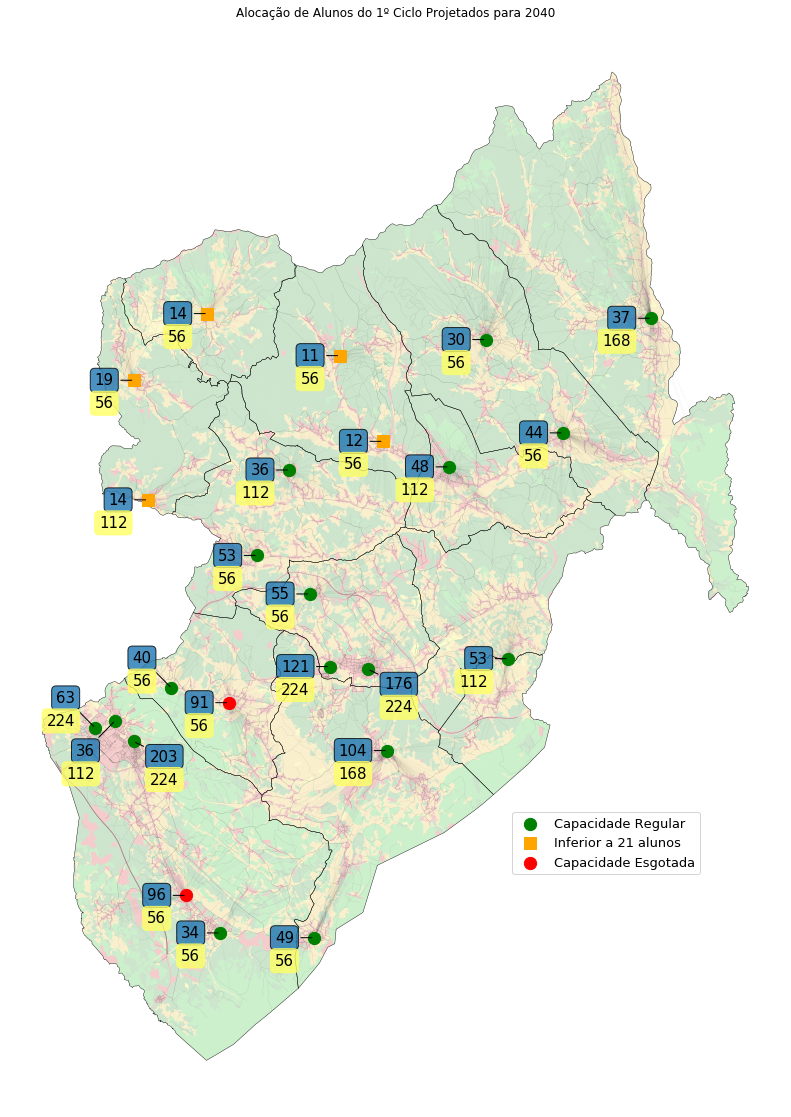

In [152]:
# Códido maluco do Jan

# # Load Data
# gdf_freguesias_CAOP2018 = gpd.read_file('./data/ourem_map_data/gdf_Freguesias_CAOP2018_Ourem.shp')
# gdf_freguesias_CAOP2018 = gdf_Freguesias_CAOP2018[gdf_Freguesias_CAOP2018['code_mun']=='1421']
# gpd_COS_municipio = gpd.read_file('./data/ourem_map_data/gpd_COS_Ourem.shp')
# gdf_open_street2019_municipio = gpd.read_file('./data/ourem_map_data/gdf_open_street2019_Ourem.shp')

# _-------------_ Uso do Solo: Categorias _-----------_


#recebe RGB em dicionários de float e devolve o hexadecimal correspondente
def rgb_to_hex (diccionario_cores): 
    dict_novo = {}
    for nome in diccionario_cores:
        dict_novo [nome] = '#%02x%02x%02x'%tuple(int(i * 255) for i in diccionario_cores[nome])
    return(dict_novo)
#define RGB para cada tipo de ocupação de solo 
colors_cos = {'Territórios artificializados': (0.8, 0, 0),
              'Agricultura': (0.9, 0.7, 0.03), 
              'Pastagens': (0.96, 0.93, 0.03),
              'Sistemas agro-florestais': (0.85, 0.6, 0),
              'Florestas': (0, 0.5, 0), 
              'Matos': (0, 0.7, 0),
              'Espaços descobertos ou com vegetação esparsa': (0.9, 0.9, 0.5),
              'Zonas húmidas': (0.9, 0.9, 0.5), 
              'Corpos de água': (0.3, 0.6, 1)}
colors_cos_hexa = rgb_to_hex(colors_cos)


# _-------------_ Estradas: Categorias _-----------_

motorway = ['motorway', 'motorway_link']
primary = ['primary', 'trunk', 'secondary']
n_mapear = ['cycleway', 'steps', 'track','track_grade1','track_grade2',
            'track_grade3','track_grade4','track_grade5','pedestrian',
            'footway', 'unclassified','path']

dict_temp = {}
for nome in gdf_open_street2019_municipio.fclass.unique(): 
    if nome in motorway:
        dict_temp [nome] = list((0.4,6))
    elif nome in primary: 
        dict_temp [nome] = list((0.3,4))
    elif nome in n_mapear:
        dict_temp [nome] = list((0.2,1))
    else: 
        dict_temp [nome] = list((0.3,2))



# _-------------_ Criação do Gráfico _-----------_





fig, ax = plt.subplots(figsize=(20, 20))

#Plota os limites das freguesias 
gdf_freguesias_CAOP2018.plot(ax=ax,
                        facecolor='None', edgecolor='black', linewidth=0.4, zorder=20)

#Plota ocupação e uso de solo por categoria, em função do esquema de cores definido em colors_cos_hexa
for categoria, data in gpd_COS_municipio.groupby('Megaclasse'):
    # Define the color for each group using the dictionary
    color = colors_cos_hexa[categoria]
    # Plot each group using the color defined above
    data.plot(color=color, ax=ax, alpha=0.2, zorder=10)

#Plota a rede de estradas, em função da linewidths e alphas definido em dict_temp 
for ctype, data in gdf_open_street2019_municipio.groupby('fclass'):
    alpha = dict_temp[ctype][0]
    linewidth = dict_temp[ctype][0]
    data.plot(color = 'black', ax=ax, alpha=alpha, 
              linewidth=linewidth, zorder=15)


linesGPD.plot(ax=ax, alpha=0.02, color='black', zorder=40)
markersize = 150
# If the School has critic mass
schools_1[(schools_1['Capacida_1']>schools_1['1_CEB_Proj_2040']) & (schools_1['Capacida_1']>0)].plot(zorder=70,ax=ax, markersize=markersize, color='green', marker='o', label='Capacidade Regular')
# IF the school is a closing Candidate
schools_1[(schools_1['Capacida_1']>0) & (schools_1['1_CEB_Proj_2040']<=22)].plot(zorder=70,ax=ax, markersize=markersize, color='#FFA500', marker='s', label='Inferior a 21 alunos ')
# If the school is Full
schools_1[(schools_1['Capacida_1']<schools_1['1_CEB_Proj_2040']) & (schools_1['Capacida_1']>0)].plot(zorder=70,ax=ax, markersize=markersize, color='red', marker='o', label='Capacidade Esgotada')
plt.legend(prop={'size':13}, bbox_to_anchor = (0.9,0.28))

for idx, row in schools_1.iterrows():
    offset = {'x':-20, 'y':0}   
    
    offset = {'x':-20, 'y':30 } if idx==0 else offset
    offset = {'x':-20, 'y':30 } if idx==9 else offset
#     offset = {'x':40, 'y':35 } if idx==24 else offset
    offset = {'x':45, 'y':-15 } if idx==10 else offset
    offset = {'x':-20, 'y':-30 } if idx==13 else offset
    offset = {'x':45, 'y':-15 } if idx==18 else offset
#     offset = {'x':40, 'y':-24 } if idx==22 else offset
#     offset = {'x':35, 'y':-20 } if idx==17 else offset
#     offset = {'y':30, 'x':-30} if idx==22
#     offset = {'y':30, 'x':-30} if idx==24
    ax.annotate(int(row['1_CEB_Proj_2040']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']), textcoords='offset points',
             size=15, ha='right', va="center", zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8),
             arrowprops=dict(arrowstyle="-", alpha=1));
    ax.annotate(int(row['Capacida_1']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']-23), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8, color='#FFFF66'),
             );
    
plt.title('Alocação de Alunos do 1º Ciclo Projetados para 2040')
    
    
ax.set_axis_off()
plt.show()

In [153]:
schools_1 =  pd.merge(schools_1, schools_enrolled, how='left', left_on=[schools_1.FID], right_on=[schools_enrolled.FID_x])

In [154]:
schools_1.head()

key_0  index   id  FID  Elegiveis                         Nome_Escol  \
0      0      0  247    0          1     1  EB da Cova da Iria (JI/EB1)   
1      1      1  261    1          1     17  EB Ourém Nascente (JI/EB1)   
2      2      2  262    2          1           2  EB do Olival (JI/EB1)   
3      3      3    0    3          1  23  EB de Urqueira Norte (JI/EB1)   
4      4      4    0    4          1       24  EB da Carvoeira (JI/EB1)   

  Codigo_DGE  Salas_Pre_  Salas_1CEB  Salas_2CEB  ...  \
0    1421416         4.0         8.0         0.0  ...   
1    1421004         3.0         4.0         0.0  ...   
2    1421752         3.0         4.0         0.0  ...   
3    1421904         1.0         2.0         0.0  ...   
4    1421643         3.0         4.0         0.0  ...   

                          point  Pre_escolar_Proj_2040  1_CEB_Proj_2040  \
0  POINT (-47068.894 -3291.236)              48.842636        63.123375   
1   POINT (-33041.594 -937.692)              37.225708        53.126883   
2   POINT (-40469.405 5467.600)              26.194252        36.718314   
3   POINT (-38767.770 9351.858)               7.595537        11.540720   
4   POINT (-35051.845 5573.907)              37.449463        48.265988   

   sum_ceb2_ceb3  FID_x  Alunos_EPE  Alunos_1CE Alunos_2CE Alunos_3CE  \
0     139.046239      0       101.0       184.0        0.0        0.0   
1      78.215777      1        34.0        55.0        0.0        0.0   
2      51.732140      2        31.0        50.0        0.0        0.0   
3      16.931951      3        25.0        20.0        0.0        0.0   
4      80.131952      4        34.0        62.0        0.0        0.0   

   Alunos_Sec  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  

[5 rows x 28 columns]

No handles with labels found to put in legend.


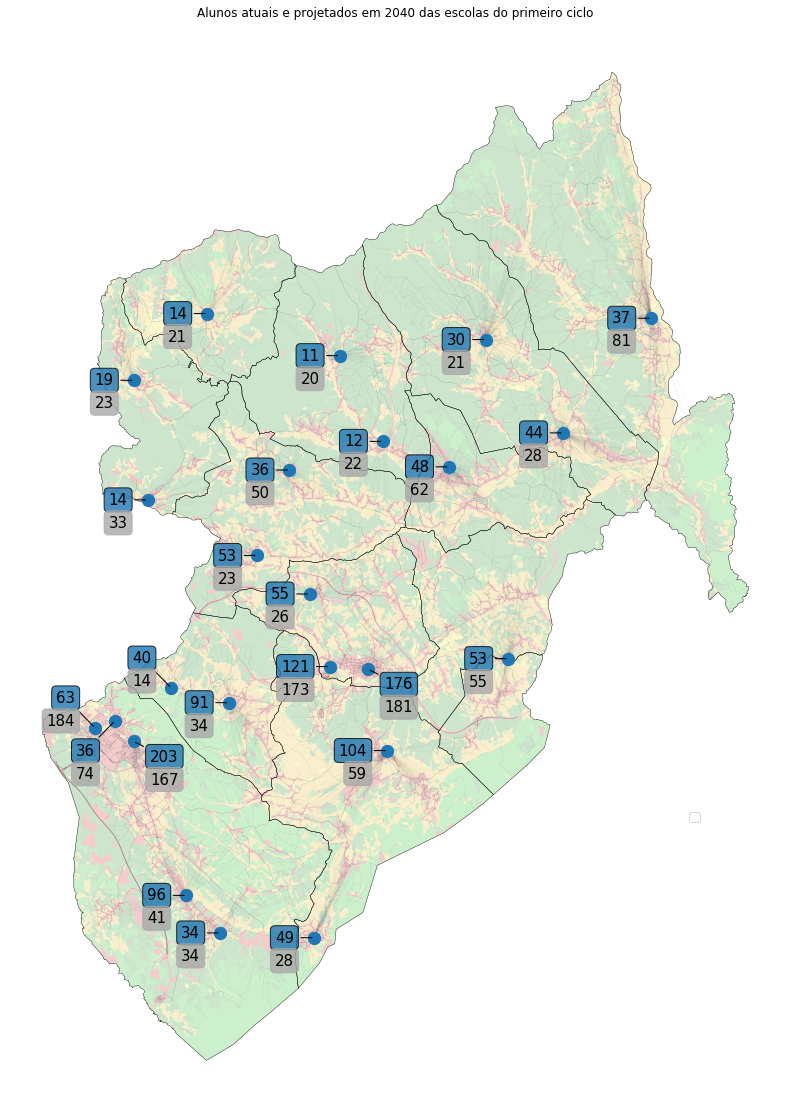

In [155]:
fig, ax = plt.subplots(figsize=(20, 20))

#Plota os limites das freguesias 
gdf_freguesias_CAOP2018.plot(ax=ax,
                        facecolor='None', edgecolor='black', linewidth=0.4, zorder=20)

#Plota ocupação e uso de solo por categoria, em função do esquema de cores definido em colors_cos_hexa
for categoria, data in gpd_COS_municipio.groupby('Megaclasse'):
    # Define the color for each group using the dictionary
    color = colors_cos_hexa[categoria]
    # Plot each group using the color defined above
    data.plot(color=color, ax=ax, alpha=0.2, zorder=10)

#Plota a rede de estradas, em função da linewidths e alphas definido em dict_temp 
for ctype, data in gdf_open_street2019_municipio.groupby('fclass'):
    alpha = dict_temp[ctype][0]
    linewidth = dict_temp[ctype][0]
    data.plot(color = 'black', ax=ax, alpha=alpha, 
              linewidth=linewidth, zorder=15)


linesGPD.plot(ax=ax, alpha=0.02, color='black', zorder=40)
markersize = 150
schools_1.plot(ax=ax, zorder=60, markersize=markersize)
plt.legend(prop={'size':13}, bbox_to_anchor = (0.9,0.28))

for idx, row in schools_1.iterrows():
    offset = {'x':-20, 'y':0}   
    
    offset = {'x':-20, 'y':30 } if idx==0 else offset
    offset = {'x':-20, 'y':30 } if idx==9 else offset
#     offset = {'x':40, 'y':35 } if idx==24 else offset
    offset = {'x':45, 'y':-15 } if idx==10 else offset
    offset = {'x':-20, 'y':-30 } if idx==13 else offset
    offset = {'x':45, 'y':-15 } if idx==18 else offset
#     offset = {'x':40, 'y':-24 } if idx==22 else offset
#     offset = {'x':35, 'y':-20 } if idx==17 else offset
#     offset = {'y':30, 'x':-30} if idx==22
#     offset = {'y':30, 'x':-30} if idx==24
    ax.annotate(int(row['1_CEB_Proj_2040']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']), textcoords='offset points',
             size=15, ha='right', va="center", zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8),
             arrowprops=dict(arrowstyle="-", alpha=1));
    ax.annotate(int(row['Alunos_1CE']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']-23), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8, color='#A9A9A9'),
             );
    
plt.title('Alunos atuais e projetados em 2040 das escolas do primeiro ciclo')
    
    
ax.set_axis_off()
plt.show()

In [156]:
# Plot 'Primario_1'
# polygon_1421 = get_required_bgri('DTMN11', '1421')
# fig, ax = plt.subplots(figsize=(15,15))
    
    
# ax.set_axis_off()

# plt.show()

#### 2 e 3 ciclo

In [157]:
schools_2 = schools[schools['Capacida_2']!=0].reset_index()
polygon_2 = polygon_1421
polygon_2.geometry = polygon_2.centroid

/home/fillipe/anaconda3/envs/pandana/lib/python3.6/site-packages/geopandas/geodataframe.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[geo_column_name] = level


In [158]:
nA = np.array(list(zip(polygon_2.geometry.x, polygon_2.geometry.y)) )
nB = np.array(list(zip(schools_2.geometry.x, schools_2.geometry.y)) )
btree = cKDTree(nB)
dist, idx = btree.query(nA, k=1)
polygon_2['place'] = idx
polygon_2['dist'] = dist

/home/fillipe/anaconda3/envs/pandana/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/fillipe/anaconda3/envs/pandana/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [159]:
# Correlate the DEMAND BGRI with the School associated
polygon_2 = pd.merge(polygon_2, schools_2[['Nome_Escol', 'point']], left_on=[polygon_2.place], how='left', right_on=[schools_2.index] )
polygon_2 = polygon_2.drop(columns='key_0')

In [160]:
listOfLines = []
for e in polygon_2.iterrows():
    line = LineString([[e[1].geometry.x, e[1].geometry.y], [e[1].point.x, e[1].point.y]])
    listOfLines.append(line)
polygon_2['line'] = listOfLines
linesGPD = gpd.GeoDataFrame(polygon_2[['BGRI11', 'dist','place', 'Nome_Escol']], geometry=polygon_2.line)

In [161]:
# Get Demand Data for each BGRI
polygon_2 = pd.merge(polygon_2, demand[['Pre_escolar_Proj_2040', '1_CEB_Proj_2040', '2_CEB_Proj_2040', '3_CEB_Proj_2040']], how='left', left_on=[polygon_2.BGRI11], right_on=[demand.index])
# Clear Polygon Data
polygon_2 = polygon_2.rename(columns={'key_0':'BGRI'})
polygon_2.index = polygon_2.BGRI
polygon_2 = polygon_2.drop(columns={'BGRI'})
polygon_2['sum_ceb2_ceb3'] = polygon_2['2_CEB_Proj_2040']+polygon_2['3_CEB_Proj_2040']

# Get the Demand for the schools
sumOfDemand = polygon_2[['Pre_escolar_Proj_2040', '1_CEB_Proj_2040','sum_ceb2_ceb3', 'place']].groupby('place').sum()
schools_2 = pd.merge(schools_2, sumOfDemand, how='left', left_on=[schools_2.index], right_on=[sumOfDemand.index])
schools_2 = schools_2.drop(columns='key_0')

In [162]:
schools_2['capacidade_total'] = schools_2['Capacida_2']+schools_2['Capacida_3']

/home/fillipe/anaconda3/envs/pandana/lib/python3.6/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


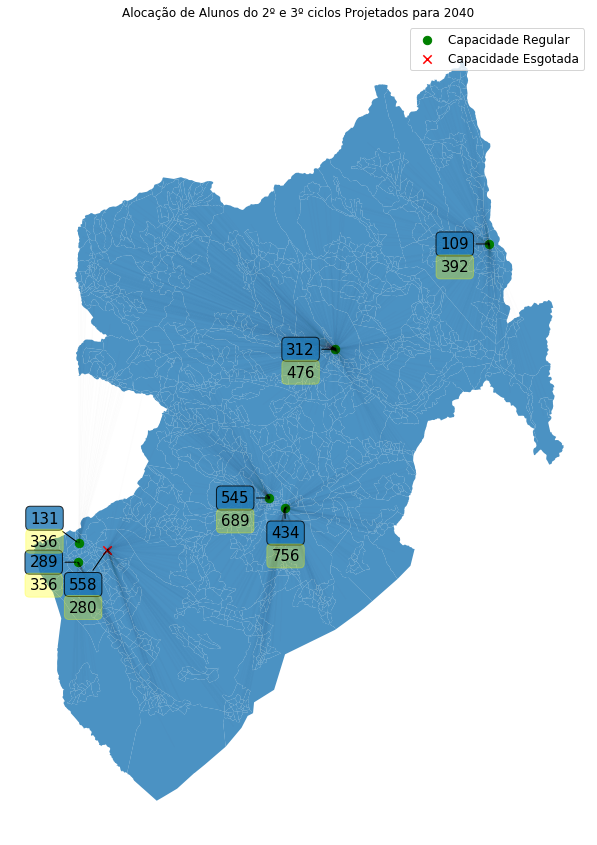

In [163]:
polygon_1421 = get_required_bgri('DTMN11', '1421')

fig, ax = plt.subplots(figsize=(15,15))
polygon_1421.plot(ax=ax, alpha=0.8)
markersize = 70
# If the School has critic mass
schools_2[(schools_2['capacidade_total']>schools_2['sum_ceb2_ceb3']) & (schools_2['capacidade_total']>0)].plot(ax=ax, markersize=markersize, color='green', marker='o', label='Capacidade Regular')
# IF the school is a closing Candidate
schools_2[(schools_2['capacidade_total']>0) & (schools_2['sum_ceb2_ceb3']<=22)].plot(ax=ax, markersize=markersize, color='yellow', marker='s', label='Subutilizada ')
# If the school is Full
schools_2[(schools_2['capacidade_total']<schools_2['sum_ceb2_ceb3']) & (schools_2['capacidade_total']>0)].plot(ax=ax, markersize=markersize, color='red', marker='x', label='Capacidade Esgotada')
plt.legend(prop={'size':12})
linesGPD.plot(ax=ax, alpha=0.009, color='black')
ax.set_axis_off()

# for idx, row in schools_2.iterrows():
#     plt.annotate(s=int(row['sum_ceb2_ceb3']), xy=(row['geometry'].x,row['geometry'].y),
#                  xytext=(row['geometry'].x+1600,row['geometry'].y+1000), horizontalalignment='center', arrowprops={'arrowstyle':'-'})


for idx, row in schools_2.iterrows():
    offset = {'x':-20, 'y':0}   

    offset = {'x':15, 'y':-25 } if idx==1 else offset
    offset = {'x':-10, 'y':-35 } if idx==3 else offset
    offset = {'x':-20, 'y':25 } if idx==4 else offset

    ax.annotate(int(row['sum_ceb2_ceb3']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']), textcoords='offset points',
             size=15, ha='right', va="center",
             bbox=dict(boxstyle="round", alpha=0.8),
             arrowprops=dict(arrowstyle="-", alpha=1));
    ax.annotate(int(row['capacidade_total']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']-23), textcoords='offset points',
             size=15, ha='right', va="center",
             bbox=dict(boxstyle="round", alpha=0.3, color='yellow'),
             );    
    
plt.title('Alocação de Alunos do 2º e 3º ciclos Projetados para 2040')     
    
plt.show()

In [164]:
polygon.to_csv('schoolByBgri_pre_kdtree.csv')
polygon_1.to_csv('schoolByBgri_1_kdtree.csv')
polygon_2.to_csv('schoolByBgri_23_kdtree.csv')


In [165]:
escolasPre = polygon[['place','Pre_escolar_Proj_2040']].groupby('place').sum()
escolasPre = pd.merge(escolasPre, schools_preEscolar[['Nome_Escol']], how='left', left_on=[escolasPre.index], right_on=[schools_preEscolar.index])
escolasPre['Media_Distancias'] = polygon[['place','dist']].groupby('place').mean()
escolasPre['max_Dist'] = polygon[['place','dist']].groupby('place').max()
escolasPre['min_Dist'] = polygon[['place','dist']].groupby('place').min()

In [166]:
escolas_1Ciclo = polygon_1[['place','1_CEB_Proj_2040']].groupby('place').sum()
escolas_1Ciclo = pd.merge(escolas_1Ciclo, schools_1[['Nome_Escol']], how='left', left_on=[escolas_1Ciclo.index], right_on=[schools_1.index])
escolas_1Ciclo['Media_Distancias'] = polygon_1[['place','dist']].groupby('place').mean()
escolas_1Ciclo['max_Dist'] = polygon_1[['place','dist']].groupby('place').max()
escolas_1Ciclo['min_Dist'] = polygon_1[['place','dist']].groupby('place').min()

In [167]:
escolas_23Ciclo = polygon_2[['place','sum_ceb2_ceb3']].groupby('place').sum()
escolas_23Ciclo = pd.merge(escolas_23Ciclo, schools_2[['Nome_Escol']], how='left', left_on=[escolas_23Ciclo.index], right_on=[schools_2.index])
escolas_23Ciclo['Media_Distancias'] = polygon_2[['place','dist']].groupby('place').mean()
escolas_23Ciclo['max_Dist'] = polygon_2[['place','dist']].groupby('place').max()
escolas_23Ciclo['min_Dist'] = polygon_2[['place','dist']].groupby('place').min()

In [168]:
escolasPre.to_excel('escolasPre.xlsx')
escolas_1Ciclo.to_excel('escolas1Ciclo.xlsx')
escolas_23Ciclo.to_excel('escolas2e3Ciclo.xlsx')

/home/fillipe/anaconda3/envs/pandana/lib/python3.6/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


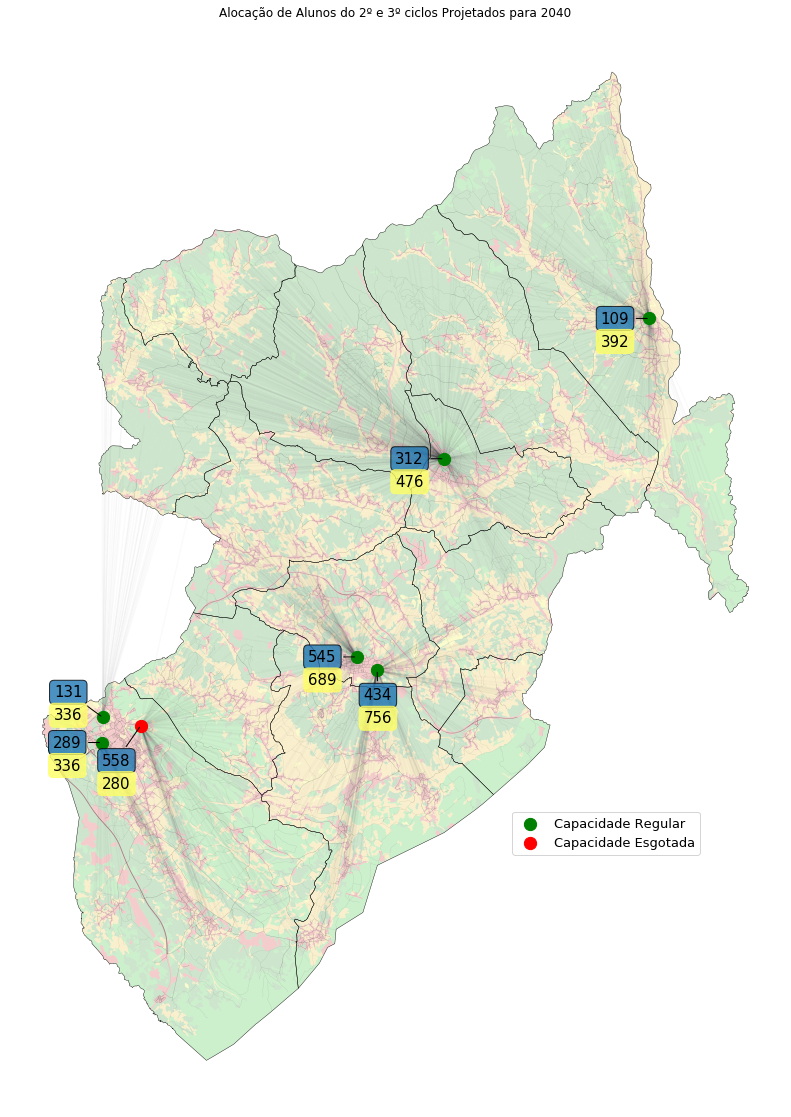

In [169]:
# Códido maluco do Jan

# # Load Data
# gdf_freguesias_CAOP2018 = gpd.read_file('./data/ourem_map_data/gdf_Freguesias_CAOP2018_Ourem.shp')
# gdf_freguesias_CAOP2018 = gdf_Freguesias_CAOP2018[gdf_Freguesias_CAOP2018['code_mun']=='1421']
# gpd_COS_municipio = gpd.read_file('./data/ourem_map_data/gpd_COS_Ourem.shp')
# gdf_open_street2019_municipio = gpd.read_file('./data/ourem_map_data/gdf_open_street2019_Ourem.shp')

# _-------------_ Uso do Solo: Categorias _-----------_


#recebe RGB em dicionários de float e devolve o hexadecimal correspondente
def rgb_to_hex (diccionario_cores): 
    dict_novo = {}
    for nome in diccionario_cores:
        dict_novo [nome] = '#%02x%02x%02x'%tuple(int(i * 255) for i in diccionario_cores[nome])
    return(dict_novo)
#define RGB para cada tipo de ocupação de solo 
colors_cos = {'Territórios artificializados': (0.8, 0, 0),
              'Agricultura': (0.9, 0.7, 0.03), 
              'Pastagens': (0.96, 0.93, 0.03),
              'Sistemas agro-florestais': (0.85, 0.6, 0),
              'Florestas': (0, 0.5, 0), 
              'Matos': (0, 0.7, 0),
              'Espaços descobertos ou com vegetação esparsa': (0.9, 0.9, 0.5),
              'Zonas húmidas': (0.9, 0.9, 0.5), 
              'Corpos de água': (0.3, 0.6, 1)}
colors_cos_hexa = rgb_to_hex(colors_cos)


# _-------------_ Estradas: Categorias _-----------_

motorway = ['motorway', 'motorway_link']
primary = ['primary', 'trunk', 'secondary']
n_mapear = ['cycleway', 'steps', 'track','track_grade1','track_grade2',
            'track_grade3','track_grade4','track_grade5','pedestrian',
            'footway', 'unclassified','path']

dict_temp = {}
for nome in gdf_open_street2019_municipio.fclass.unique(): 
    if nome in motorway:
        dict_temp [nome] = list((0.4,6))
    elif nome in primary: 
        dict_temp [nome] = list((0.3,4))
    elif nome in n_mapear:
        dict_temp [nome] = list((0.2,1))
    else: 
        dict_temp [nome] = list((0.3,2))



# _-------------_ Criação do Gráfico _-----------_





fig, ax = plt.subplots(figsize=(20, 20))

#Plota os limites das freguesias 
gdf_freguesias_CAOP2018.plot(ax=ax,
                        facecolor='None', edgecolor='black', linewidth=0.4, zorder=20)

#Plota ocupação e uso de solo por categoria, em função do esquema de cores definido em colors_cos_hexa
for categoria, data in gpd_COS_municipio.groupby('Megaclasse'):
    # Define the color for each group using the dictionary
    color = colors_cos_hexa[categoria]
    # Plot each group using the color defined above
    data.plot(color=color, ax=ax, alpha=0.2, zorder=10)

#Plota a rede de estradas, em função da linewidths e alphas definido em dict_temp 
for ctype, data in gdf_open_street2019_municipio.groupby('fclass'):
    alpha = dict_temp[ctype][0]
    linewidth = dict_temp[ctype][0]
    data.plot(color = 'black', ax=ax, alpha=alpha, 
              linewidth=linewidth, zorder=15)


markersize = 150
# If the School has critic mass
schools_2[(schools_2['capacidade_total']>schools_2['sum_ceb2_ceb3']) & (schools_2['capacidade_total']>0)].plot(zorder=70, ax=ax, markersize=markersize, color='green', marker='o', label='Capacidade Regular')
# IF the school is a closing Candidate
schools_2[(schools_2['capacidade_total']>0) & (schools_2['sum_ceb2_ceb3']<=22)].plot(zorder=70,ax=ax, markersize=markersize, color='#FFA500', marker='s', label='Subutilizada ')
# If the school is Full
schools_2[(schools_2['capacidade_total']<schools_2['sum_ceb2_ceb3']) & (schools_2['capacidade_total']>0)].plot(zorder=70, ax=ax, markersize=markersize, color='red', marker='o', label='Capacidade Esgotada')

linesGPD.plot(ax=ax, alpha=0.02, color='black', zorder=40)
ax.set_axis_off()

# for idx, row in schools_2.iterrows():
#     plt.annotate(s=int(row['sum_ceb2_ceb3']), xy=(row['geometry'].x,row['geometry'].y),
#                  xytext=(row['geometry'].x+1600,row['geometry'].y+1000), horizontalalignment='center', arrowprops={'arrowstyle':'-'})


for idx, row in schools_2.iterrows():
    offset = {'x':-20, 'y':0}   

    offset = {'x':15, 'y':-25 } if idx==1 else offset
    offset = {'x':-10, 'y':-35 } if idx==3 else offset
    offset = {'x':-20, 'y':25 } if idx==4 else offset

    ax.annotate(int(row['sum_ceb2_ceb3']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']), textcoords='offset points',
             size=15, ha='right', va="center", zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8),
             arrowprops=dict(arrowstyle="-", alpha=1));
    ax.annotate(int(row['capacidade_total']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']-23), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8, color='#FFFF66'),
             );    
    
plt.legend(prop={'size':13}, bbox_to_anchor = (0.9,0.28))
plt.title('Alocação de Alunos do 2º e 3º ciclos Projetados para 2040')     
         
ax.set_axis_off()
plt.show()

In [170]:
schools_2 =  pd.merge(schools_2, schools_enrolled, how='left', left_on=[schools_2.FID], right_on=[schools_enrolled.FID_x])

In [171]:
schools_2['alocados_total'] = schools_2['Alunos_2CE']+schools_2['Alunos_3CE']

No handles with labels found to put in legend.


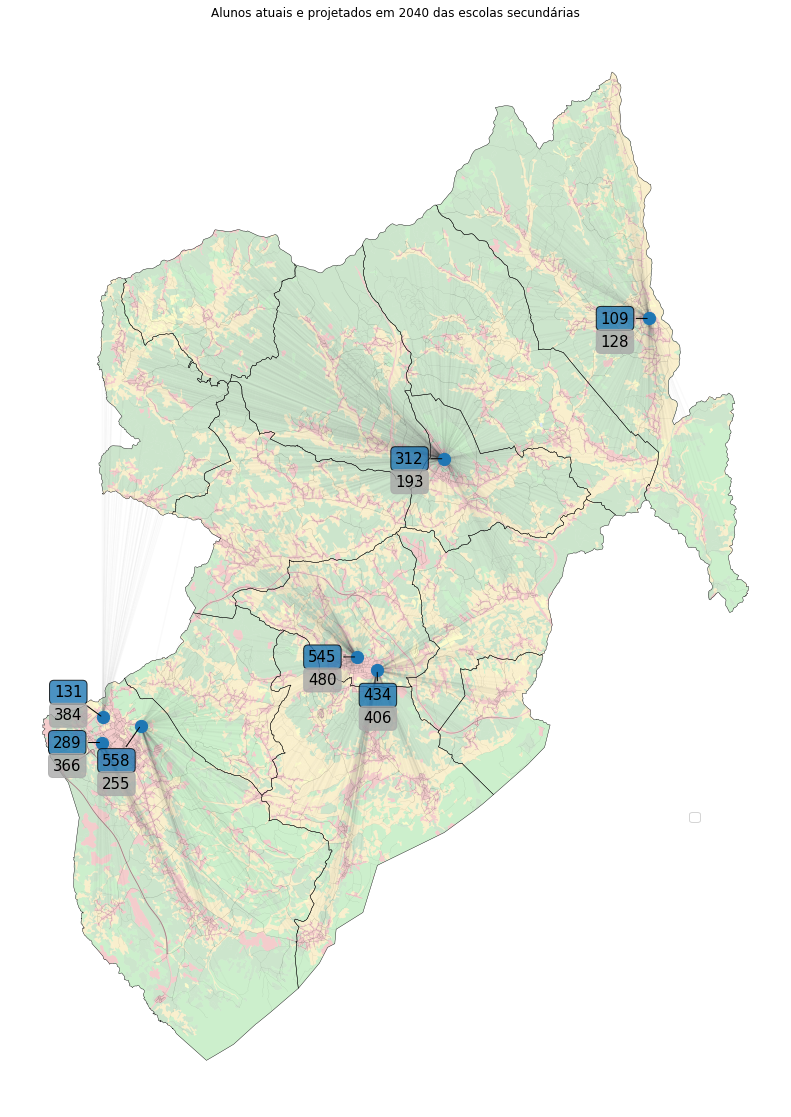

In [172]:


fig, ax = plt.subplots(figsize=(20, 20))

#Plota os limites das freguesias 
gdf_freguesias_CAOP2018.plot(ax=ax,
                        facecolor='None', edgecolor='black', linewidth=0.4, zorder=20)

#Plota ocupação e uso de solo por categoria, em função do esquema de cores definido em colors_cos_hexa
for categoria, data in gpd_COS_municipio.groupby('Megaclasse'):
    # Define the color for each group using the dictionary
    color = colors_cos_hexa[categoria]
    # Plot each group using the color defined above
    data.plot(color=color, ax=ax, alpha=0.2, zorder=10)

#Plota a rede de estradas, em função da linewidths e alphas definido em dict_temp 
for ctype, data in gdf_open_street2019_municipio.groupby('fclass'):
    alpha = dict_temp[ctype][0]
    linewidth = dict_temp[ctype][0]
    data.plot(color = 'black', ax=ax, alpha=alpha, 
              linewidth=linewidth, zorder=15)


markersize = 150
schools_2.plot(ax=ax, zorder=70, markersize=markersize)
linesGPD.plot(ax=ax, alpha=0.02, color='black', zorder=40)
ax.set_axis_off()

# for idx, row in schools_2.iterrows():
#     plt.annotate(s=int(row['sum_ceb2_ceb3']), xy=(row['geometry'].x,row['geometry'].y),
#                  xytext=(row['geometry'].x+1600,row['geometry'].y+1000), horizontalalignment='center', arrowprops={'arrowstyle':'-'})


for idx, row in schools_2.iterrows():
    offset = {'x':-20, 'y':0}   

    offset = {'x':15, 'y':-25 } if idx==1 else offset
    offset = {'x':-10, 'y':-35 } if idx==3 else offset
    offset = {'x':-20, 'y':25 } if idx==4 else offset

    ax.annotate(int(row['sum_ceb2_ceb3']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']), textcoords='offset points',
             size=15, ha='right', va="center", zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8),
             arrowprops=dict(arrowstyle="-", alpha=1));
    ax.annotate(int(row['alocados_total']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']-23), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8, color='#A9A9A9'),
             );    
    
plt.legend(prop={'size':13}, bbox_to_anchor = (0.9,0.28))
plt.title('Alunos atuais e projetados em 2040 das escolas secundárias')     
         
ax.set_axis_off()
plt.show()

In [173]:
# # Códido maluco do Jan

# # Load Data
# gdf_freguesias_CAOP2018 = gpd.read_file('./data/ourem_map_data/gdf_Freguesias_CAOP2018_Ourem.shp')
# gdf_freguesias_CAOP2018 = gdf_Freguesias_CAOP2018[gdf_Freguesias_CAOP2018['code_mun']=='1421']
# gpd_COS_municipio = gpd.read_file('./data/ourem_map_data/gpd_COS_Ourem.shp')
# gdf_open_street2019_municipio = gpd.read_file('./data/ourem_map_data/gdf_open_street2019_Ourem.shp')

# _-------------_ Uso do Solo: Categorias _-----------_


#recebe RGB em dicionários de float e devolve o hexadecimal correspondente
def rgb_to_hex (diccionario_cores): 
    dict_novo = {}
    for nome in diccionario_cores:
        dict_novo [nome] = '#%02x%02x%02x'%tuple(int(i * 255) for i in diccionario_cores[nome])
    return(dict_novo)
#define RGB para cada tipo de ocupação de solo 
colors_cos = {'Territórios artificializados': (0.8, 0, 0),
              'Agricultura': (0.9, 0.7, 0.03), 
              'Pastagens': (0.96, 0.93, 0.03),
              'Sistemas agro-florestais': (0.85, 0.6, 0),
              'Florestas': (0, 0.5, 0), 
              'Matos': (0, 0.7, 0),
              'Espaços descobertos ou com vegetação esparsa': (0.9, 0.9, 0.5),
              'Zonas húmidas': (0.9, 0.9, 0.5), 
              'Corpos de água': (0.3, 0.6, 1)}
colors_cos_hexa = rgb_to_hex(colors_cos)


# _-------------_ Estradas: Categorias _-----------_

motorway = ['motorway', 'motorway_link']
primary = ['primary', 'trunk', 'secondary']
n_mapear = ['cycleway', 'steps', 'track','track_grade1','track_grade2',
            'track_grade3','track_grade4','track_grade5','pedestrian',
            'footway', 'unclassified','path']

dict_temp = {}
for nome in gdf_open_street2019_municipio.fclass.unique(): 
    if nome in motorway:
        dict_temp [nome] = list((0.4,6))
    elif nome in primary: 
        dict_temp [nome] = list((0.3,4))
    elif nome in n_mapear:
        dict_temp [nome] = list((0.2,1))
    else: 
        dict_temp [nome] = list((0.3,2))



# _-------------_ Criação do Gráfico _-----------_



def create_municipalities_plots(ax):
    #Plota os limites das freguesias 
    gdf_freguesias_CAOP2018.plot(ax=ax,
                            facecolor='None', edgecolor='black', linewidth=0.4, zorder=20)

    #Plota ocupação e uso de solo por categoria, em função do esquema de cores definido em colors_cos_hexa
    for categoria, data in gpd_COS_municipio.groupby('Megaclasse'):
        # Define the color for each group using the dictionary
        color = colors_cos_hexa[categoria]
        # Plot each group using the color defined above
        data.plot(color=color, ax=ax, alpha=0.2, zorder=10)

    #Plota a rede de estradas, em função da linewidths e alphas definido em dict_temp 
    for ctype, data in gdf_open_street2019_municipio.groupby('fclass'):
        alpha = dict_temp[ctype][0]
        linewidth = dict_temp[ctype][0]
        data.plot(color = 'black', ax=ax, alpha=alpha, 
              linewidth=linewidth, zorder=15)



def plot_projected_students(ax, df_school): 
    
    markersize = 150
    # # If the School has critic mass
    # schools_2[(schools_2['capacidade_total']>schools_2['sum_ceb2_ceb3']) & (schools_2['capacidade_total']>0)].plot(zorder=70, ax=ax, markersize=markersize, color='green', marker='o', label='Capacidade Regular')
    # # IF the school is a closing Candidate
    # schools_2[(schools_2['capacidade_total']>0) & (schools_2['sum_ceb2_ceb3']<=22)].plot(zorder=70,ax=ax, markersize=markersize, color='#FFA500', marker='s', label='Subutilizada ')
    # # If the school is Full
    # schools_2[(schools_2['capacidade_total']<schools_2['sum_ceb2_ceb3']) & (schools_2['capacidade_total']>0)].plot(zorder=70, ax=ax, markersize=markersize, color='red', marker='o', label='Capacidade Esgotada')

    # linesGPD.plot(ax=ax, alpha=0.02, color='black', zorder=40)
    ax.set_axis_off()

    # for idx, row in schools_2.iterrows():
    #     plt.annotate(s=int(row['sum_ceb2_ceb3']), xy=(row['geometry'].x,row['geometry'].y),
    #                  xytext=(row['geometry'].x+1600,row['geometry'].y+1000), horizontalalignment='center', arrowprops={'arrowstyle':'-'})

    df_school.plot(ax=ax, markersize=markersize, zorder=200)
    for idx, row in df_school.iterrows():
        offset = {'x':-20, 'y':0}   

        offset = {'x':55, 'y':-15 } if idx==0 else offset


        
        ax.annotate(int(row['Alunos_Sec']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8, color='#A9A9A9'),
             );  
        ax.annotate(int(row['Capacida_4']), xy=(row['geometry'].x,row['geometry'].y),
                 xytext=(offset['x'], offset['y']-23), textcoords='offset points',
                 size=15, ha='right', va="center",zorder=200,
                 bbox=dict(boxstyle="round", alpha=0.8, color='#FFFF66'),
                 arrowprops=dict(arrowstyle="-", alpha=1));    
        
        

    plt.legend(prop={'size':13}, bbox_to_anchor = (0.9,0.28))
    plt.title('Alunos atuais e projetos em 2040 das escolas secundárias')     

    ax.set_axis_off()
    plt.show()
 

No handles with labels found to put in legend.


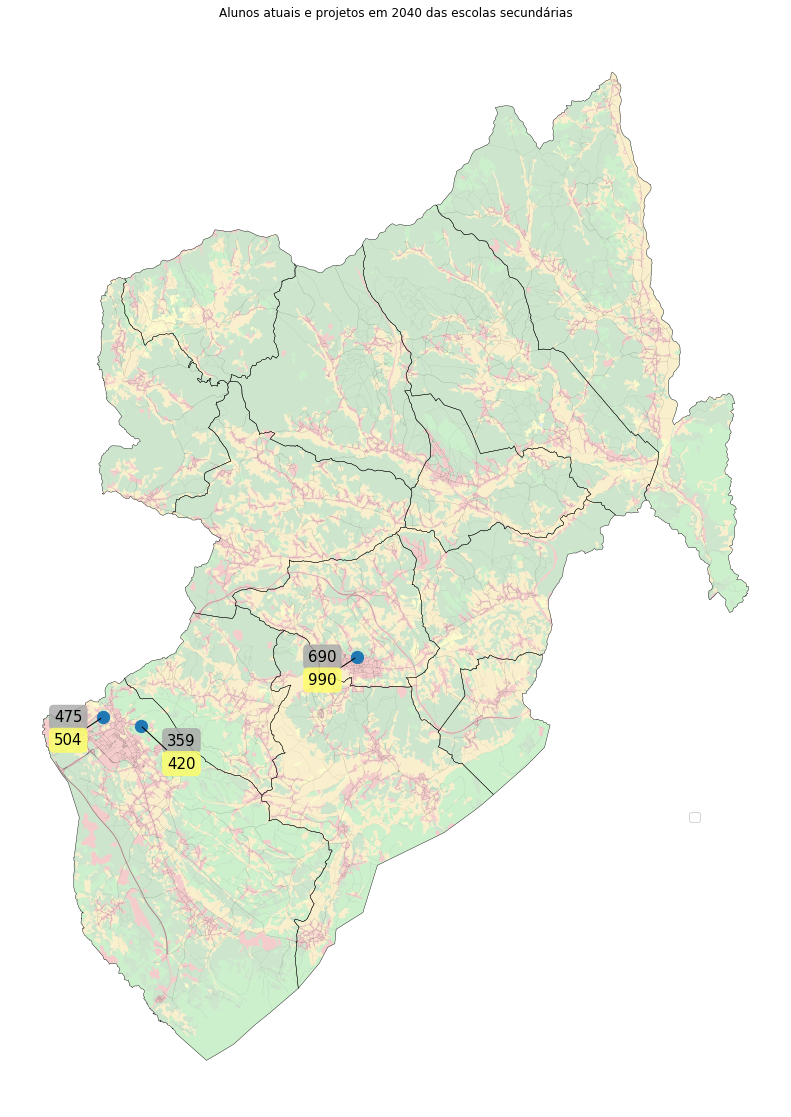

In [174]:
   
schools_secundario = schools[schools['Capacida_4']>0]
schools_secundario = pd.merge(schools_secundario, schools_enrolled, how='left', left_on=[schools_secundario.FID], right_on=[schools_enrolled.FID_x] )


fig, ax = plt.subplots(figsize=(20, 20))

create_municipalities_plots(ax)
plot_projected_students(ax,schools_secundario)

NameError: name 'schools_secundario' is not defined